## Exploratory Data Analysis

This notebook fulfills two main purposes:

1. Intake the data from the exported json files and clean it up
2. Get an idea of wha the data holds

Intaking the data requires reading each of the 1,380 individual data files, converting them into individual Pandas DataFrames and then creating one big, unified DataFrame that is easier to work with. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import re

### Utility Functions and Data Parsing

In [2]:
# maps shorthands in sample filenames to "english" translations of what they stand for
fname_shorthand_dict = {
    "b": "batch_size",
    "k": "kernel_size",
    "s": "stride_length",
    "f": "filter_count"
}


def parse_sample_filename(fname):
    """
    Parameters:
        fname: string of a sample filename (no file extension)
        
    Returns:
        params: characters in fname 
        vals: values corresponding to those characters
        
    This method is used for decoding the paramter values encoded in the filenames of samples
    >>> parse_sample_filename("a1b2c10")
    >>> (['a', 'b', 'c'], ['1', '2', '10'])
    """
    params = re.findall("[a-zA-Z]{1}", fname)
    
    # translating param shorthand to "English" name
    params = list(map(lambda x: fname_shorthand_dict[x], params))
    
    vals = re.findall("[0-9]+", fname) 
    
    # converting vals from strings to integers
    vals = list(map(int, vals))

    return params, vals


### Loading Data from Disk and Creating a DataFrame

In [3]:
# Location of json files containing profile data
# default location is DataHonorsThesis/data/export_logs/
data_location = "../../data/"
export_logs = data_location + "export_logs/"
# storing a dictionary of sample names to sample DataFrames
# will eventually be used to extract meaningful data and create one big DataFrame
sample_dfs = []

# goes through every .json file in the data_base_path directory and turns it into a DataFrame
# these DataFrames are then added into the sample_dfs dict for further processing
# this can take up to a minute to run
for fname in os.listdir(export_logs):
    # appending the base path to the filename so it can be loaded by pandas
    full_fname = export_logs + fname
    
    # only read in json
    if full_fname.endswith(".json"):
        #print("Reading: %s" %fname)
        json_raw = pd.read_json(
            path_or_buf = full_fname,
            orient = "records"
        )
        
        # TODO: change this script to using functions like map, flatmap, etc.
        
        # extract column names from first row of first col in loaded json
        col_names = [json_raw.cols[0][i]["id"] for i in range(len(json_raw.cols[0]))]
        
        # split the single row loaded from the json into 1 array per row
        rows = [json_raw.rows[0][i]["c"] for i in range(len(json_raw.rows[0]))]
        # transform "rows" (current lists of dicts) into lists of values
        rows = [[row[i]["v"] for i in range(len(row))] for row in rows]
        #print(col_names)
        #print(rows[0])
        
        # now that rows and columns have been extracted, turn them into a 'real' DataFrame
        formatted_df = pd.DataFrame(data=rows, columns=col_names)
        
        # add the values for experimental parameters (e.g. strides, ) as new columns to our dataframe
        params, vals = parse_sample_filename(re.sub(".json", "", fname))
        
        #print(params)
        formatted_df[params] = pd.DataFrame([vals], index = formatted_df.index)
        
        # adding our new DataFrame to the sample_dfs dict with key = fname
        # (sub to cut off the '.json' from the filename)
        sample_dfs.append(formatted_df)
        

In [4]:
# uncomment this for an example of what one of the sample dataframes should look like
#sample_dfs[0].head()

In [5]:
# Combining sample D
concat_df = pd.concat(sample_dfs)

# converting some "object" dtype columns to strings
concat_df["kernel_name"] = concat_df["kernel_name"].astype(str)
concat_df["op_name"] = concat_df["op_name"].astype(str)

### Exploring the Data

In [6]:
# printing the schema of our combined DataFrame
print("DataFrame Shape: ", concat_df.shape)
print("Columns (and dtypes):")
print(concat_df.dtypes)

DataFrame Shape:  (79115, 18)
Columns (and dtypes):
rank                             int64
kernel_name                     object
registers_per_thread             int64
shmem_bytes                      int64
block_dim                       object
grid_dim                        object
is_op_tensor_core_eligible        bool
is_kernel_using_tensor_core       bool
op_name                         object
occurrences                      int64
total_duration_us              float64
avg_duration_us                float64
min_duration_us                float64
max_duration_us                float64
batch_size                       int64
stride_length                    int64
kernel_size                      int64
filter_count                     int64
dtype: object


In [7]:
print("Sample Records from concat_df:")
concat_df.head()

Sample Records from concat_df:


,rank,kernel_name,registers_per_thread,shmem_bytes,block_dim,grid_dim,is_op_tensor_core_eligible,is_kernel_using_tensor_core,op_name,occurrences,total_duration_us,avg_duration_us,min_duration_us,max_duration_us,batch_size,stride_length,kernel_size,filter_count
0,1,"void fft2d_r2c_32x32<float, false, 0u, false>(...",0,0,"1,1,1","1,1,1",True,False,gradient_tape/sequential_1020/conv2d_1020/Conv...,2,57.504,28.752,28.736,28.768,127,1,1,1
1,2,void cudnn::detail::implicit_convolve_sgemm<fl...,0,0,"1,1,1","1,1,1",True,False,sequential_1020/conv2d_1020/Conv2D,1,37.696,37.696,37.696,37.696,127,1,1,1
2,3,"void gemv2T_kernel_val<int, int, float, float,...",0,0,"1,1,1","1,1,1",True,False,sequential_1020/dense_1020/MatMul,1,14.304,14.304,14.304,14.304,127,1,1,1
3,4,"void flip_filter<float, float>(float*, float c...",0,0,"1,1,1","1,1,1",True,False,gradient_tape/sequential_1020/conv2d_1020/Conv...,1,13.728,13.728,13.728,13.728,127,1,1,1
4,5,"void gemv2T_kernel_val<int, int, float2, float...",0,0,"1,1,1","1,1,1",True,False,gradient_tape/sequential_1020/conv2d_1020/Conv...,1,12.448,12.448,12.448,12.448,127,1,1,1


Many of the columns in the above DataFrame store information about performance metrics outside the range of what is being studied in this experiment. To make the DataFrame easier to work with, we'll filter out some of this information before continuing further.

In [8]:
# 
filtered_cols = concat_df[["kernel_name", "op_name", "stride_length", "filter_count", "batch_size", 
                           "total_duration_us", "kernel_size", "avg_duration_us", "min_duration_us", "max_duration_us"]]

### Filtering out information about kernels other than Conv2D

Since the test network was composed of more layers than just the Conv2D (as described in the sampling notebook), our current DataFrame contains a lot of performance information about these other layers. While they are interesting to study, this analysis focuses on the Conv2D layer, so we will filter out the other layers, creating a new DataFrame (conv2d_kernels)

Furthermore, it is common that within each layer there are multiple kernels that are used during computation. To study the network on a layer level, we can group these different kernels together (the DataFrame conv2d_layers).

In [9]:
conv2d_kernels = filtered_cols[filtered_cols["op_name"].str.endswith("Conv2D")].copy()

conv2d_layers = conv2d_kernels.groupby(
    by=["op_name", "stride_length", "filter_count", "kernel_size" ,"batch_size"]).sum().reset_index().copy()

# moving op_name back to the index
conv2d_layers.set_index("op_name", inplace=True)
conv2d_kernels.reset_index(inplace=True)
conv2d_kernels.set_index("op_name", inplace=True)
conv2d_kernels.drop(["index"], axis=1, inplace=True)

# doing  quick verification that everything turned out alright

# should contain 1380 unique rows
print("Output Shape: ", conv2d_layers.shape)

# Checking that all parameters made it into the filtered DataFrame
print("Batch Sizes: ", np.sort(conv2d_layers.batch_size.unique()))
print("Kernel Sizes: ", np.sort(conv2d_layers.kernel_size.unique()))
print("Stride Length: ", np.sort(conv2d_layers.stride_length.unique()))
print("Filter Counts: ", np.sort(conv2d_layers.filter_count.unique()))

conv2d_layers.head()

Output Shape:  (1380, 8)
Batch Sizes:  [  1   2   3   4   5   7   8   9  15  16  17  31  32  33  63  64  65 127
 128 129 319 320 321]
Kernel Sizes:  [1 3]
Stride Length:  [1 2 3]
Filter Counts:  [ 1  2  3  4  5  6  7  8  9 10]


,stride_length,filter_count,kernel_size,batch_size,total_duration_us,avg_duration_us,min_duration_us,max_duration_us
op_name,,,,,,,,
sequential/conv2d/Conv2D,1,1,1,1,20.703,20.703,20.703,20.703
sequential_1/conv2d_1/Conv2D,1,2,1,1,21.312,21.312,21.312,21.312
sequential_10/conv2d_10/Conv2D,1,1,3,1,24.288,24.288,24.288,24.288
sequential_100/conv2d_100/Conv2D,3,1,1,2,19.008,19.008,19.008,19.008
sequential_1000/conv2d_1000/Conv2D,3,1,1,65,20.608,20.608,20.608,20.608


Looking at the table output above, it seems like the total, min, avg and max duration columns all contain the same value for every row. Let's see if this is true.

In [10]:
print("Total and Avg Same: ", (conv2d_layers["total_duration_us"] == conv2d_layers["avg_duration_us"]).all())
print("Total and Max Same: ",(conv2d_layers["total_duration_us"] == conv2d_layers["max_duration_us"]).all())
print("Total and Min Same: ",(conv2d_layers["total_duration_us"] == conv2d_layers["min_duration_us"]).all())

Total and Avg Same:  True
Total and Max Same:  True
Total and Min Same:  True


In [11]:
print("Total and Avg Same: ", (conv2d_kernels["total_duration_us"] == conv2d_kernels["avg_duration_us"]).all())
print("Total and Max Same: ",(conv2d_kernels["total_duration_us"] == conv2d_kernels["max_duration_us"]).all())
print("Total and Min Same: ",(conv2d_kernels["total_duration_us"] == conv2d_kernels["min_duration_us"]).all())

Total and Avg Same:  True
Total and Max Same:  True
Total and Min Same:  True


Thus we only need to keep one copy of this column. Intuitively, this should make sense since we sampled for a single run. (Do this for both the kernels and layers DataFrames)

(Note, we could also do a supporting verification of this fact by looking at the "Occurences" column in the original DataFrame and noticing that no Conv2D kernels have a value greater than 1 here)

In [12]:
conv2d_layers.drop(["avg_duration_us", "max_duration_us", "min_duration_us"], axis =1, inplace=True)
conv2d_kernels.drop(["avg_duration_us", "max_duration_us", "min_duration_us"], axis =1, inplace=True)

### First Look at the Data: total_duration_us

Now that we have an idea of the schema of our data and have done some initial cleaning and organization to make the data easy to work with, lets explore some of the columns. 

In this section, we'll focus primarily on the value of "total_duration_us" in the conv2d_layers column since this will be the main focus when looking at how certain parameters affect runtime. 

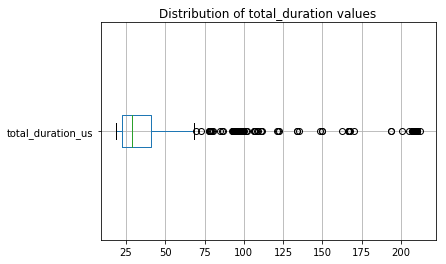

In [21]:
td_boxplot = conv2d_layers.boxplot(column="total_duration_us", vert=False)
td_boxplot.set_title("Distribution of total_duration values")
plt.show()

This boxplot shows the distribution of values in the total_distribution_us, ignoring all other parameters. Seeing this helps give a perspective on what the range of the values we are dealing with is. From this, we can tell that many samples are concentrated under 50us, and the data has a large tail on the right. 

In some sense though, this plot is somewhat misleading - by number there are much more trials taken at "small" batch sizes compared to "large". (Some refer to this as "Attribute Value Skew") Let's try splitting the data by batch_size. 

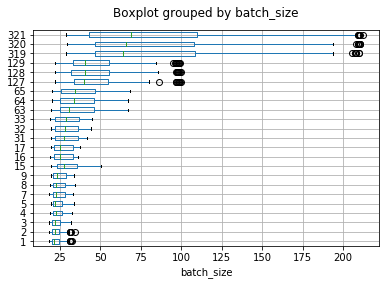

In [24]:
td_boxplot = conv2d_layers.boxplot(column="total_duration_us", by="batch_size", vert=False)
td_boxplot.set_title("")
plt.show()

Splitting by batch size shows that it has a clear impact on total_duration, which is not unexpected. 

There's a lot to unpack from this chart! For example, notice how up until batch_size enters the 60s, the medians of individual boxplots stay in roughly the same range. 

We'll take a note of this, and it will be one of the relationships analyzed in the data_analysis notebook. 

### Saving the DataFrame for Later Use

To save us from having to intake all the json files every time we want to access the data, we'll save our two DataFrames as CSVs for easy recovery

In [13]:
# Storing the DataFrame as a CSV, since it is easy to do with Pandas
# the string data_location is the directory containing the export_logs folder as used above
conv2d_kernels.to_csv(path_or_buf = (data_location + "conv2d_kernels.csv"))
conv2d_layers.to_csv(path_or_buf = (data_location + "conv2d_layers.csv"))